In [437]:
import numpy as np
import sympy as sp
from IPython.display import display
from itertools import permutations
from copy import deepcopy

from qiskit import transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.visualization import plot_histogram
from qiskit import Aer, execute
from qiskit.circuit import Parameter
from qiskit.providers.aer import StatevectorSimulator
import networkx as nx

from scipy.optimize import minimize


In [438]:
#### HELPER FUNCTION ####
def string_to_arr(string):
    arr = []
    for str in string: arr.append(int(str))
    return np.array(arr).reshape((len(np.array(arr)),1))
    

def score_sequence(arr):
    """Function for computing sum-of-pairs score
       according to scheme defined in 
       score function. 
    Args:
        arr: numpy array, e.g.: np.array(["A","C","_","T","_"])
    Returns:
        final_score: integer 
       """
    final_score = 0
    for n1 in range(0 , len(arr)):
        for n2 in range(n1 + 1 , len(arr)):
            final_score += score(arr[n1],arr[n2])
    return final_score

def recursive_perm_scoring(mat, perms, test_mat, row_idx):
    """Computing all possibles alignment scores of MSA matrix; mat,
       given the permutations for each of the N-1 rows of mat, (found in perms)
    
    Args:
        mat     : 2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                              ['A', 'C', '_', '_'],
                                              ['A', 'T', '_', '_']])
        perms   : all distinct permutations of the N-1 last rows of mat
        test_mat: matrix 
       """
    perm_history, score_history = [], []
    if row_idx < mat.shape[0]:
        for i in range(0 , len(perms[row_idx - 1])):
            test_mat[row_idx,:] = perms[row_idx - 1][i]
            score_list, perm_list = recursive_perm_scoring(mat, perms, test_mat, row_idx + 1)
            perm_history += perm_list
            score_history += score_list
            current_score = 0
            for j in range(0 , mat.shape[1]):
                current_score += score_sequence(test_mat[:,j])
            score_history.append(current_score)
            perm_history.append(deepcopy(test_mat))
    return score_history, perm_history


def matrix_2_bit_state(my_matrix,original_matrix):
    """
    Maps some given matrix repr. of a MSA "my_matrix" to a corresponding
    bitstring via the column encoding, whilst respecting
    original order in "original_matrix"
    x_(s,n,i) determines whether the n'th letter of the s'th string
    is placed in the i'th column.

    Args:
        mat: 2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                         ['A', 'C', '_', '_'],
                                         ['A', 'T', '_', '_']])
    Returns:
        numpy array containing bit repr., e.g.: np.array([1,0,0,1...])

    """
    ## Initial definitions
    current_matrix = deepcopy(my_matrix)
    nr_of_rows, nr_of_cols, gap = current_matrix.shape[0], current_matrix.shape[1], "_"
    ## List of nr of letters in i'th row of original matrix
    nr_letters_in_mat = [len(np.where(original_matrix[i] != "_")[0]) for i in range(nr_of_rows)]
    ## Needed nr of registers
    regs = np.array([list(np.zeros(nr_of_cols)) for i in range(np.sum(nr_letters_in_mat))])
    ## List of lists of letters in original matrix rows
    original_letters = np.array([list(original_matrix[i][np.where(original_matrix[i] != gap)[0]]) 
                                 for i in range(nr_of_rows)], dtype=object)
    #print(regs)
    ## List of lists of letters in current matrix rows
    current_letters = np.array([list(current_matrix[i][np.where(current_matrix[i] != gap)[0]]) 
                                for i in range(nr_of_rows)], dtype=object)

    for s in range(0 , nr_of_rows):
        for n in range(0 , len(current_letters[s])):
            ## Finding index
            #print("current s:",s)
            #print("Setting:",current_letters[s][n])
            #print("where term:",np.where(np.array(original_letters[s]) == current_letters[s][n])[0][0])
            #print("sum term:",s * int(np.sum(nr_letters_in_mat[:s])))
            reg_idx = np.where(np.array(original_letters[s]) == current_letters[s][n])[0][0] + int(np.sum(nr_letters_in_mat[:s])) # Original n'th idx
            #print("reg. idx.:",reg_idx)
            col_idx = np.where(np.array(current_matrix[s])   == current_letters[s][n])[0][0]                                      # Current i'th idx
            #print("col. idx.:", col_idx)
            ## Setting reg value
            regs[reg_idx][col_idx] = 1
            ## Changing comparator to "O" (the letter) in case of multiple of same char
            original_letters[s][np.where(np.array(original_letters[s]) == current_letters[s][n])[0][0]] = "O"
            current_matrix[s][ np.where(np.array(current_matrix[s])  == current_letters[s][n])[0][0]] = "O"
            #print(original_letters,current_letters)
            #print("_________________")
    return regs.flatten()


def bit_state_2_matrix(bit_string,init_mat):
    """
    Maps some given bitstring repr. of a MSA to a corresponding
    matrix via the initial matrix. 

    Args:
        bit_string: numpy array containing bit repr., e.g.: np.array([1,0,0,1...])
        mat       : 2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                                ['A', 'C', '_', '_'],
                                                ['A', 'T', '_', '_']])
    Returns:
        2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                    ['A', 'C', '_', '_'],
                                    ['A', 'T', '_', '_']])
    """
    letters_in_mat = [init_mat[i][j] for i in range(init_mat.shape[0]) 
                      for j in range(init_mat.shape[1]) if init_mat[i][j] != "_"]
    assert np.sum(bit_string) == len(letters_in_mat), "Invalid state - to few ones in bitstring"

    counts, letters, gap = [], [], "_"
    for row in range(init_mat.shape[0]):
        current_count = 0
        current_letters  = []
        for col in range(init_mat.shape[1]):
            if init_mat[row][col] != gap: 
                current_count += 1
                current_letters.append(init_mat[row][col])
        letters.append(current_letters)
        counts.append(current_count)

    lower = 0
    multiplier, regs = init_mat.shape[1], []
    for value in counts:
        for i in range(value):
            regs.append(bit_string[lower + i * multiplier : lower + (i + 1) * multiplier])
        lower += value * multiplier

    counter = 0
    new_mat = np.zeros((init_mat.shape),dtype=object)
    counter = 0
    for i in range(len(letters)):
        for j in range(len(letters[i])):
            col_idx = np.where(regs[counter] == 1)[0][0]
            new_mat[i][col_idx] = letters[i][j]
            counter += 1

    new_mat[new_mat == 0] = "_"
    return new_mat


def legal_permutations(arr): 
    """ Function for computing all permutations of array
    of type ["A","C","_","T","_"] that maintains original
    order of characters != "_" .

    Args:
        arr: numpy array, e.g.: np.array(["A","C","_","T","_"])
    Returns:
        2D numpy array of legal permutations, e.g.: np.array([["A","C","_","T","_"],
                                                              ["A","C","_","_","T"],...])

    """
    legal_perm_indices = []
    letter_order = [char for char in arr if char != "_"]
    perms = list(set(permutations(arr))) # Using set to remove dubs
    perms = [list(perm) for perm in perms]
    for idx, perm in enumerate(perms):
        letter_counter = 0
        keep_perm = True
        for letter in perm:
            if letter != "_":
                if letter_order[letter_counter] != letter:
                    keep_perm = False
                else: letter_counter += 1
        if keep_perm: legal_perm_indices.append(idx)
    return np.array(perms)[legal_perm_indices]

def recursive_brute_force(init_mat):
    """ Final recursive version of brute force scoring of all relevant
    permutations of variable sized MSA matrix. 
    (Make sure the longest row containin only letters are
     initially placed at top of matrix)
     
    Args:
        Init_mat: 2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                              ['A', 'C', '_', '_'],
                                              ['A', 'T', '_', '_']])
    Returns:
        best_score: Integer
        best perms: list of corresponding permutations of MSA matrix
    """
    perms = []
    for row_idx in range(1 , init_mat.shape[0]):
        perms.append(legal_permutations(init_mat[row_idx,:]))
    test_mat = np.zeros((init_mat.shape) , dtype=object)
    test_mat[0,:] = init_mat[0,:]
    score_history, mat_history = recursive_perm_scoring(init_mat,perms,test_mat,1)
    best_score = np.min(score_history)
    best_perms = [mat_history[i] for i in range(len(mat_history)) if score_history[i] == best_score]
    return best_score, best_perms


def score_matrix(mat: np.ndarray) -> int:
    """Function for calculating the alignment score
    of a MSA matrix"""
    final_score = 0
    for col in range(0 , mat.shape[1]):
        final_score += score_sequence(mat[:,col])
    return final_score

def initial_MSA_matrix(init_strings):
    """ Creating a matrix representation of the strings given
    and filling gaps with "_"

    Args:
        list of strings, e.g. ["ACCT","AC","AT"]

    Returns:
        2D numpy array
    """
    ## Asurring longest string on top
    lengths = np.array([len(str) for str in init_strings])
    strings = init_strings[np.flip(np.argsort(lengths, kind="heap"))]
    initial_matrix = np.zeros((len(strings) , np.max(lengths)),dtype=object)
    for row in range(initial_matrix.shape[0]):
        for col in range(len(strings[row])):
            initial_matrix[row][col] = strings[row][col]
    initial_matrix[initial_matrix == 0] = "_"
    return initial_matrix
    
## Function for indexing states
def index_state(M,n,s,i,Ns_vals):
    """Indexing n,s,i from 1,... and adding N_0 = 0 to start og N_s vals"""
    return M * ((n-1) + np.sum(Ns_vals[:s])) + i - 1

## Function for indexing given weight term in array
def index_weight(s1,n1,s2,n2,i,M, nr_letters):
    #w_mat_row_idx = (n1 - 1) + (s1-1) * M + (nr_letters[s2] - 1) * M
    w_mat_row_idx = (n1 - 1) + (s2-2) * M + (s1-1) * M
    w_mat_col_idx = n2 - 1
    return w_mat_row_idx, w_mat_col_idx

def score(n1,n2):
    """ Function for computing the score of
        some alignment of the two chars n1, n2
    Args:
        n1: any str in {"_","A","T","C","G"}
        n2: any str in {"_","A","T","C","G"}
    Returns:
        score: int in {-1,0,1}
    """
    score = None
    gap = "_"
    if   n1 == gap or n2 == gap: score =  0; return score
    elif n1 == n2              : score = -1; return score
    elif n1 != n2              : score =  1; return score


def encode_score_weights(mat):
    """Encoding the score of all possible alignments
        for all n1, n2 for all s1 < s2 score(n1,n2)

    Args:
        mat: 2D numpy array, e.g. array([['A', 'C', 'C', 'T'],
                                         ['A', 'C', '_', '_'],
                                         ['A', 'T', '_', '_']])   
    Returns:
        weight_matrices: 3D numpy array of shape (1/2 * (L - 1) * L , C , C)
                         where L = nr. of rows and C = nr. of cols in
                         matrix given
    """
    L, C = mat.shape
    weight_matrices = [np.zeros((C,C)) for i in range(int(1/2 * (L - 1) * L))]
    for row1 in range(0 , mat.shape[0]):
        for row2 in range(row1 + 1 , mat.shape[0]):
            for idx1, n1 in enumerate(mat[row1,:]):
                for idx2, n2 in enumerate(mat[row2,:]):
                    weight_matrices[row1+row2-1][idx1][idx2] = score(n1,n2)
    return np.vstack(np.array(weight_matrices))

def encode_QUBO(Weights: np.ndarray, MSA: np.ndarray, penalties: np.ndarray):

    nr_rows,nr_cols = MSA.shape[0], MSA.shape[1]
    nr_letters = [0] + [len(np.where(MSA[i] != "_")[0]) for i in range(nr_rows)]
    vector_dim = np.sum(nr_letters) * nr_cols

    p1,p2,p3   = penalties[0], penalties[1], penalties[2]

    Q = p1 * np.identity(vector_dim)
    h = -2 * p1 *np.ones(vector_dim).reshape((vector_dim,1))
    d = p1 * np.sum(nr_letters)
        
    ## Weight terms
    for s1 in range(1 , nr_rows + 1):
        for s2 in range(s1 + 1, nr_rows + 1):
            for n1 in range(1 , nr_letters[s1]+ 1):
                for n2 in range(1 , nr_letters[s2] + 1):
                    for i in range(1 , nr_cols + 1):
                        xsni1_idx=index_state(nr_cols,n1,s1,i,nr_letters)
                        xsni2_idx=index_state(nr_cols,n2,s2,i,nr_letters)
                        row,col = index_weight(s1,n1,s2,n2,i,nr_cols,nr_letters)
                        Q[xsni1_idx][xsni2_idx] = Weights[row][col]

    ## Remaing part of squared terms in one col pr. letter
    for s in range(1 , nr_rows + 1):
        for n in range(1 , nr_letters[s] + 1):
            for i in range(1 , nr_cols + 1):
                for j in range(i + 1, nr_cols + 1):
                    xsni1_idx=index_state(nr_cols,n,s,i,nr_letters)
                    xsni2_idx=index_state(nr_cols,n,s,j,nr_letters)
                    Q[xsni2_idx][xsni1_idx] = 2 * p1

    ## One letter pr. ith col terms
    for s in range(1 , nr_rows + 1):
        for i in range(1 , nr_cols + 1):
            for n1 in range(1 , nr_letters[s]+ 1):
                for n2 in range(n1 + 1 , nr_letters[s] + 1):
                    xsni1_idx=index_state(nr_cols,n1,s,i,nr_letters)
                    xsni2_idx=index_state(nr_cols,n2,s,i,nr_letters)
                    Q[xsni1_idx][xsni2_idx] = 1 * p2
    
    ## Ordering term
    for s in range(1 , nr_rows + 1):
        for n1 in range(1 , nr_letters[s]+ 1):
            for n2 in range(n1 + 1 , nr_letters[s] + 1):
                for i1 in range(1 , nr_cols + 1):
                    for i2 in range(i1 + 1 , nr_cols + 1):
                        xsni1_idx=index_state(nr_cols,n1,s,i2,nr_letters)
                        xsni2_idx=index_state(nr_cols,n2,s,i1,nr_letters)
                        Q[xsni1_idx][xsni2_idx] = 1 * p3
    
    return Q,h,d



def calculate_cost(Weights: np.ndarray, MSA: np.ndarray, state: np.ndarray, penalties: np.ndarray):
    nr_rows,nr_cols = MSA.shape[0], MSA.shape[1]
    nr_letters = [0] + [len(np.where(MSA[i] != "_")[0]) for i in range(nr_rows)]
    vector_dim = np.sum(nr_letters) * nr_cols
    p1,p2,p3   = penalties[0], penalties[1], penalties[2]
    
    weight_terms = 0
    ## Weight terms
    for s1 in range(1 , nr_rows + 1):
        for s2 in range(s1 + 1, nr_rows + 1):
            for n1 in range(1 , nr_letters[s1]+ 1):
                for n2 in range(1 , nr_letters[s2] + 1):
                    for i in range(1 , nr_cols + 1):
                        xsni1_idx=index_state(nr_cols,n1,s1,i,nr_letters)
                        xsni2_idx=index_state(nr_cols,n2,s2,i,nr_letters)
                        row,col = index_weight(s1,n1,s2,n2,i,nr_cols,nr_letters)
                        weight_terms += state[xsni1_idx]*state[xsni2_idx] * Weights[row][col]

    p2_terms = 0
    ## One letter pr. ith col terms
    for s in range(1 , nr_rows + 1):
        for i in range(1 , nr_cols + 1):
            for n1 in range(1 , nr_letters[s]+ 1):
                for n2 in range(n1 + 1 , nr_letters[s] + 1):
                    xsni1_idx=index_state(nr_cols,n1,s,i,nr_letters)
                    xsni2_idx=index_state(nr_cols,n2,s,i,nr_letters)
                    p2_terms += state[xsni1_idx]*state[xsni2_idx]
    
    p3_terms = 0
    ## Ordering term
    for s in range(1 , nr_rows + 1):
        for n1 in range(1 , nr_letters[s]+ 1):
            for n2 in range(n1 + 1 , nr_letters[s] + 1):
                for i1 in range(1 , nr_cols + 1):
                    for i2 in range(i1 + 1 , nr_cols + 1):
                        xsni1_idx=index_state(nr_cols,n1,s,i2,nr_letters)
                        xsni2_idx=index_state(nr_cols,n2,s,i1,nr_letters)
                        p3_terms += state[xsni1_idx]*state[xsni2_idx]
    
    p1_terms = 0
    ## Remaing part of squared terms in one col pr. letter
    for s in range(1 , nr_rows + 1):
        for n in range(1 , nr_letters[s] + 1):
            current_sum = 0
            for i in range(1 , nr_cols + 1):
                    xsni1_idx=index_state(nr_cols,n,s,i,nr_letters)
                    current_sum += state[xsni1_idx]
            p1_terms += (current_sum - 1) ** 2
    final_cost = weight_terms + p1 * p1_terms + p2 * p2_terms + p3 * p3_terms
    return final_cost 


In [439]:
def compute_expectation(counts , Q , h , d , weights, penalties , msa):
    
    """
    Computes expectation value based on measurement results

    """
    avg = 0
    sum_count = 0
    for bitstring, count in counts.items():
        state = string_to_arr(bitstring)
        #score = ((state.T @ (Q @ state)) + (h.T @ state) + d)[0][0]
        score = calculate_cost(weights , msa , state.T[0] , penalties)
        avg += score * count
        sum_count += count
    return avg/sum_count

def create_qaoa_circ(initial_MSA , edges , penalties , theta):
    
    """
    Creates a parametrized qaoa circuit

    """
    letters_in_mat = [initial_MSA[i][j] for i in range(initial_MSA.shape[0]) 
                      for j in range(initial_MSA.shape[1]) if initial_MSA[i][j] != "_"]
    
    nqubits = int(len(letters_in_mat) *  initial_MSA.shape[1])  # Number of qubits = number of nodes in graph 
    p       = len(theta)//2                                     # Number of alternating unitaries
    qc      = QuantumCircuit(nqubits)                           # Initializing Q circuit w. nqubits nr. of qbits

    beta  = theta[:p]                # Beta opt param for mixing unitaries as first p vals.
    gamma = theta[p:]                # Gama opt param for cost unitaries as last p vals.
    
    p1, p2, p3 = penalties[0], penalties[1], penalties[2]

    
    # Initial_state: Hadamark gate on each qbit
    for i in range(0, nqubits):
        qc.h(i)
    
    # Cost unitary:
    for irep in range(0, p):        
        for i, j, w_ij in edges:
            if i!= j:
                qc.rzz(2 * gamma[irep] * w_ij , i , j)
            else:
                qc.rz(2 * gamma[irep] * w_ij  , i  )   # Diagonal in Q matrix
                qc.rz(2 * gamma[irep] * (-1 * p1) , i) # Elements of h vector

    # mixer unitary: X rotation on each qbit      
    for irep in range(0, p): 
        for i in range(0, nqubits):
            qc.rx(2 * beta[irep], i)
            
    qc.measure_all()        
    return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(initial_MSA: np.ndarray, Q: np.ndarray , h: np.ndarray , 
                    d: float , edges: list , p: int , weights, penalties, shots=512):
    
    """
    Runs parametrized circuit
    
    """
    #backend = StatevectorSimulator(precision="double")
    backend = Aer.get_backend('qasm_simulator')
    #backend.shots = shots
    
    def execute_circ(theta):
        
        qc = create_qaoa_circ(initial_MSA , edges , penalties , theta)
        #qc = qc.decompose()
        #qc = transpile(qc,optimization_level=3)
        counts = backend.run(qc,seed_simulator=10).result().get_counts()
        return compute_expectation(counts , Q , h , d , weights,penalties, initial_MSA) ## Returns the expectation of graph, given counts
    
    return execute_circ

def columnwise_norm(mat):
    for i in range(mat.shape[1]):
        mat[:,i] *= 1 / np.sum(mat[:,i])

def rowwise_norm(mat):
    for i in range(mat.shape[0]):
        mat[i] *= 1 / np.sum(mat[i])

In [440]:
initial_strings = np.array(["G","AG"])
penalties = np.array([4,4,4])
my_mat = initial_MSA_matrix(initial_strings)
print("--- Initial MSA ---")
print(my_mat)
print("--- Chosen penalties ---")
print(penalties)
state = matrix_2_bit_state(my_mat,my_mat)
state = state.reshape((len(state),1))
weights = encode_score_weights(my_mat)
Q,h,d = encode_QUBO(weights,my_mat,penalties)

max_terms= np.array([np.max(Q),np.max(h)])
Q *= 1./np.max(max_terms)
h *= 1./np.max(max_terms)

edges = [] # List of triplets [(i_1,j_1,w_i1j1),(i_2,j_2,w_i2j2),...]
for idx1 in range(Q.shape[1]):
    for idx2 in range(Q.shape[0]):
        if Q[idx1][idx2] != 0:
            edges.append((idx1,idx2,Q[idx1][idx2]))


--- Initial MSA ---
[['A' 'G']
 ['G' '_']]
--- Chosen penalties ---
[4 4 4]


In [441]:
p = 3
expectation = get_expectation(my_mat,Q,h,d,edges,p,weights,penalties)
options = {"disp":True,"maxiter": 1000}
res = minimize(fun = expectation, x0 = np.ones(p), method='COBYLA',options = options)
res

     fun: 5.8359375
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 40
  status: 1
 success: True
       x: array([1.24017331, 0.88983369, 1.        ])


   Normal return from subroutine COBYLA

   NFVALS =   40   F = 5.835938E+00    MAXCV = 0.000000E+00
   X = 1.240173E+00   8.898337E-01   1.000000E+00


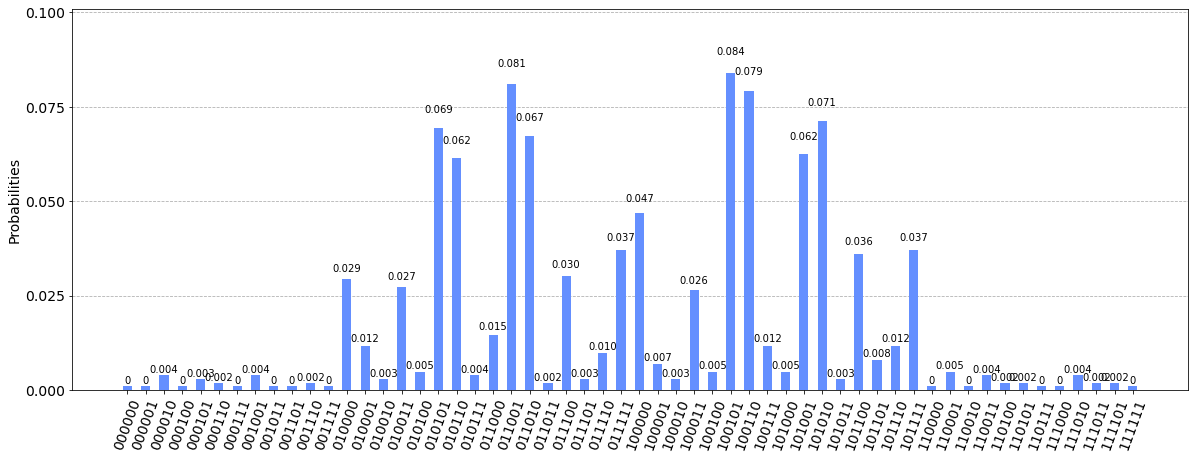

In [442]:
from qiskit.visualization import plot_histogram

backend = Aer.get_backend('aer_simulator')
#backend = StatevectorSimulator(precision="double")


qc = create_qaoa_circ(my_mat, edges, penalties, res.x)
#qc = qc.decompose()
#qc = transpile(qc,optimization_level=3)

counts = backend.run(qc,seed_simulator=10).result().get_counts()
plot_histogram(counts,figsize=(20,7))

In [443]:
def get_solutions(lim: int, counts):
    idxs = np.flip(np.argsort(list(counts.values())))
    return np.array(list(counts.keys()))[idxs][:lim]

best_solutions = get_solutions(len(list(counts.values())),counts)
states = [string_to_arr(solution) for solution in best_solutions]
idx = 0
states[idx],bit_state_2_matrix(states[idx],my_mat)

(array([[1],
        [0],
        [0],
        [1],
        [0],
        [1]]),
 array([['A', 'G'],
        ['_', 'G']], dtype=object))